Scrapeando DATA USA

Guía de la API: https://www.census.gov/foreign-trade/reference/guides/Guide%20to%20International%20Trade%20Datasets.pdf

Solicitar una key para hacer más de 500 calls por día: http://api.census.gov/data/key_signup.html

Requerimientos del ejercicio:

a. Se quiere generar el archivo llamado "expo-usa-arg-{año}-{mes}.csv" que contenga el volumen de expos de USA a ARG para todas las commodities y el período que se solicita es: Año: 2020 Meses: de enero (incluido) hasta abril (incluido).

b. Se deben incluir en el archivo las siguientes columnas:

 - Nombre de Pais destino
 - Código de commodity a nivel armonizado hs10
 - Nombre de commodity (descripción)
 - Valor mensual
 - Año
 - Mes

c. Opcional: Realizar gráficos para poder visualizar la información de manera conveniente

# Puntos claves que se tuvieron en cuenta:

Antes de ejecutar la extracción de datos, procedimiento a analizar la documentación e ir investigando parte por parte todos los parámetros posibles a ingresar, así como tambíen las variantes de los mismos para generar una carga de datos lo más dinámica y automática posible.

### Parametros ausar en hs
* hs E_COMMODITY, E_COMMODITY_LDESC, E_COMMODITY_SDESC

### Posible devolución de 204 (sin datos)
* https://api.census.gov/data/timeseries/intltrade/exports/enduse?get=E_ENDUSE,E_ENDUSE_LDESC,CTY_CODE,ALL_VAL_MO,ALL_VAL_YR&YEAR=2013&MONTH=01&CTY_CODE=2470&E_ENDUSE=00100

### Se hacen varias llamadas a commodities de la sieguiente manera, para que no falle por cantidad de datos
* https://api.census.gov/data/timeseries/intltrade/imports/porths?get=PORT,CTY_CODE,I_COMMODITY,GEN_VAL_MO,AIR_VAL_MO,AIR_WGT_MO&YEAR=2017&MONTH=09&SUMMARY_LVL=DET&COMM_LVL=HS6&I_COMMODITY=1*

### Como debería ser la consulta para hs10
* https://api.census.gov/data/timeseries/intltrade/exports/hs?get=CTY_CODE,CTY_NAME,ALL_VAL_MO,ALL_VAL_YR&time=2013-06

### SUMMARY_LVL trae agrupado por regiones o no dependiendo de   CGP and DET
* https://api.census.gov/data/timeseries/intltrade/exports/hs?get=CTY_CODE,CTY_NAME,A#LL_VAL_MO,ALL_VAL_YR&SUMMARY_LVL&time=2013-06

###Fijar el nivel de commodities
* https://api.census.gov/data/timeseries/intltrade/imports/hs?get=I_COMMODITY,GEN_VAL_MO&time=2013-01&COMM_LVL=HS10





# Importación de la API:

Partiendo de una URI "base", le incoporamos en variables adicionales todos los parámetros necesario para cumplir con los datos requeridos para la generación de CSV.

La intención de ejecturarlo de esta forma fue para que la consulta mediante la API quede lo más dinámica posible y, si fuera necesario consultar otros periodos, otros productos, paises, etc, solo se deba modificar dichos parámetros y no la URI completa.

Como parte de esta carga de datos, en la etapa de iteración de datos, introducimos variables para el manejo de errores que nos sirvan de alerta en caso de existir fallas en la carga y poder conocer desde donde provienen las mismas.

In [2]:
import requests
import pandas as pd
import time

#Uri exportación
linkBase='https://api.census.gov/data/timeseries/intltrade/exports/hs?get='
#Parametros HS
#E_COMMODITY,CTY_CODE, #Al consultar por estos campos ya los agrega como columnas, así que no se ponen para no traer columnas duplicadas
linkBase+='E_COMMODITY_SDESC,E_COMMODITY_LDESC,CTY_NAME,ALL_VAL_MO,ALL_VAL_YR,MONTH,YEAR'
#nivel de sumarización
linkBase+='&SUMMARY_LVL'
#Fecha/s a consultar
linkBase+='&time=from+2020-01+to+2020-04'
#Nivel de commodity
linkBase+='&COMM_LVL=HS10'
#País a consultar
linkBase+='&CTY_CODE=3570'

#Las consultas (llamadas al servicio) se podrían dividir por fecha, país y commodity
#En este caso dada la cantidad de los datos se hizo solo por commodity, como para tener un ejemplo de lo pedido en clase originalmente

eCommodities=[0,1,2,3,4,5,6,7,8,9]
data=pd.DataFrame()

try:

  for nCommodity in eCommodities:
    url= linkBase + f'&E_COMMODITY={nCommodity}*'

    intentos = 1
    while intentos <= 10:
      resp=requests.get(url)
      if resp.status_code==200:
        data=data.append(pd.DataFrame(resp.json()).drop(0))
        intentos = 11
      else: 
        time.sleep(5)
        intentos += 1

  if resp.status_code==200:
    data.columns=resp.json()[0]
    #print(data)
  else:  
    print(f'Verificar.Despues de intentar 10 veces el servidor ha devuelto la respuesta: {resp.status_code}')

except:
  print('Error al obtener la información del servidor')

Chequeamos que dentro del DF generado no existan duplicados, para poder decidir si es necesario realizar una limpieza de datos para resolver la duplicidad

In [3]:
data.duplicated().sum()

0

Indicamos el remplazo de posibles datos nulos dentro de columnas numericas con vistas puestas a la futura generación de gráficos.

In [4]:
import numpy as np
#data.info
data['ALL_VAL_MO'].replace(np.nan, 0, inplace  = True)
data['ALL_VAL_YR'].replace(np.nan, 0, inplace  = True)

In [5]:
#Ordenar por commodity y time (o año mes)
data.sort_values(by=['E_COMMODITY','YEAR','MONTH'], ascending=True, inplace=True)
data

,E_COMMODITY_SDESC,E_COMMODITY_LDESC,CTY_NAME,ALL_VAL_MO,ALL_VAL_YR,MONTH,YEAR,SUMMARY_LVL,time,COMM_LVL,CTY_CODE,E_COMMODITY
1,"HORSES, PUREBRED BREEDING, LIVE","HORSES, PUREBRED BREEDING, LIVE",ARGENTINA,90000,90000,01,2020,DET,2020-01,HS10,3570,0101210000
2,"HORSES, PUREBRED BREEDING, LIVE","HORSES, PUREBRED BREEDING, LIVE",ARGENTINA,0,90000,02,2020,DET,2020-02,HS10,3570,0101210000
3,"HORSES, PUREBRED BREEDING, LIVE","HORSES, PUREBRED BREEDING, LIVE",ARGENTINA,0,90000,03,2020,DET,2020-03,HS10,3570,0101210000
4,"HORSES, PUREBRED BREEDING, LIVE","HORSES, PUREBRED BREEDING, LIVE",ARGENTINA,361100,451100,04,2020,DET,2020-04,HS10,3570,0101210000
5,"HORSES, LIVE, EXCEPT PUREBRED BREEDING","HORSES, LIVE, EXCEPT PUREBRED BREEDING",ARGENTINA,35000,35000,04,2020,DET,2020-04,HS10,3570,0101290000
...,...,...,...,...,...,...,...,...,...,...,...,...
960,"ARTICLES DONATED FOR RELIEF OR CHARITY, NESOI",ARTICLES DONATED FOR RELIEF OR CHARITY BY INDI...,ARGENTINA,4762,4762,04,2020,DET,2020-04,HS10,3570,9802400000
961,"LOW VALUE ESTIMATE, EXCLUDING CANADA","LOW VALUE ESTIMATE, EXCLUDING CANADA",ARGENTINA,14501069,14501069,01,2020,DET,2020-01,HS10,3570,9880004000
962,"LOW VALUE ESTIMATE, EXCLUDING CANADA","LOW VALUE ESTIMATE, EXCLUDING CANADA",ARGENTINA,13802629,28303698,02,2020,DET,2020-02,HS10,3570,9880004000
963,"LOW VALUE ESTIMATE, EXCLUDING CANADA","LOW VALUE ESTIMATE, EXCLUDING CANADA",ARGENTINA,15563130,43866828,03,2020,DET,2020-03,HS10,3570,9880004000


# Generación del CSV

Luego de la carga y análisis del DF generado, incorporamos la generación de los archivos CSV solicitados en la consigna.

Tomamos la decisión de que al momento de generar los mencionado archivos se genere un diccionario que contendra el mes y año que deberá contener el mismo, para automátizar la exportación a CSV.

In [ ]:
#Obtener los pares (anio,mes) presentes en el archivo
s_anio_mes=data.groupby(('YEAR')).MONTH.unique()  #Chequear que esto funcione ok

for anio, meses in s_anio_mes.items():
  for mes in meses:
    #Hacer una mascara por mes y generar el archivo
    mask = (data['YEAR'] == anio) & (data['MONTH'] == mes)
    data_out = data.loc[mask]
    data_out.to_csv(f'/content/sample_data/expo-usa-arg-{anio}-{mes}.csv', 
                    columns=['CTY_NAME', 'E_COMMODITY', 'E_COMMODITY_SDESC', 'ALL_VAL_MO', 'YEAR','MONTH'])

# Visualizaciones

Luego de la carga y limpieza de datos, y del posterior análisis de la información que almacena el DF, se decidió realizar algunos gráficos que describan los datos que nos devuelve el llamado a la API.

In [ ]:
import plotly.express  as px

#Tomamos del DF los acumulados anuales al mes de Abril (04) para los 10 Commodities con los Mayores valores
data["ALL_VAL_YR"] = pd.to_numeric(data["ALL_VAL_YR"])
data_10_comm_top = data[data['MONTH']=='04'][['E_COMMODITY','E_COMMODITY_SDESC','CTY_NAME','ALL_VAL_MO','ALL_VAL_YR','MONTH','YEAR']].sort_values(by='ALL_VAL_YR',ascending=False).head(10)
data_10_comm_top

In [18]:
#Utilizando la libreria Plotly Express graficamos los 10 mayores Commodities. Utilizamos los colores para establecer leyendas dinamicas por código
fig = px.bar(data_10_comm_top, y= 'ALL_VAL_YR', x='E_COMMODITY_SDESC', hover_data = data_10_comm_top[['ALL_VAL_YR','E_COMMODITY']], color='E_COMMODITY', width=1200, title='Top 10 Commodities: Totales Acumulados Enero-Abril 2020 ')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

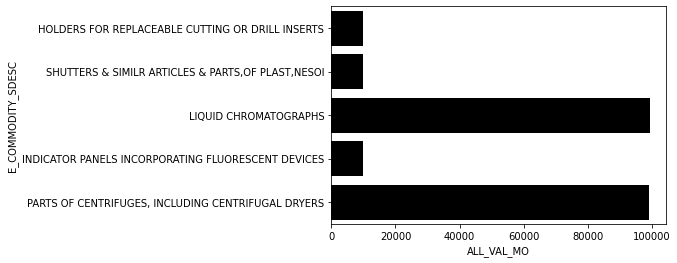

In [ ]:
import seaborn as sns
#Tome los top 5 del mes de enero y lo guarde en df_top_expMes1
df_top_expMes1=data[data['MONTH']== '01'].sort_values('ALL_VAL_MO',ascending=False).head(5)
df_top_expMes1["ALL_VAL_MO"] = pd.to_numeric(df_top_expMes1["ALL_VAL_MO"])
#grafico
sns.barplot(x='ALL_VAL_MO', y='E_COMMODITY_SDESC', data=df_top_expMes1, orient='h', color='k')

In [ ]:
import seaborn as sns
#Tomo los 5 commodity mas exportados y lo cargo en df_top_mayorImportado
df_top_mayorImportado=data.sort_values('ALL_VAL_MO',ascending=False).head(5)

#en commodity_top guardo los codigos de commoditys
commodity_top = df_top_mayorImportado['E_COMMODITY']
#Despues filtro de data los commoditys que estan en commodity_top y los guardardo en df_comodity_top 
df_comodity_top = data[data.E_COMMODITY.isin(commodity_top)]
df_comodity_top["ALL_VAL_MO"] = pd.to_numeric(df_comodity_top["ALL_VAL_MO"])
df_comodity_top

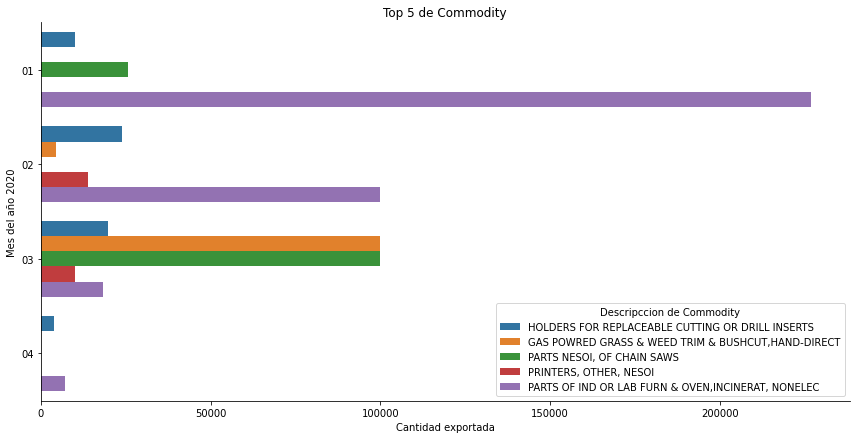

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#sns.barplot(x='ALL_VAL_MO', y='MONTH', hue='E_COMMODITY_SDESC', data=df_comodity_top, orient='h', saturation=.5)
sns.catplot(x='ALL_VAL_MO', y='MONTH', hue='E_COMMODITY_SDESC', data=df_comodity_top, kind = "bar", height = 6, aspect = 2,legend =False )
plt.title("Top 5 de Commodity")
plt.xlabel("Cantidad exportada")
plt.ylabel("Mes del año 2020")
plt.legend(title = 'Descripccion de Commodity')

Text(0.5, 1.0, 'Exportaciones por meses (01/04 - 04/04)')

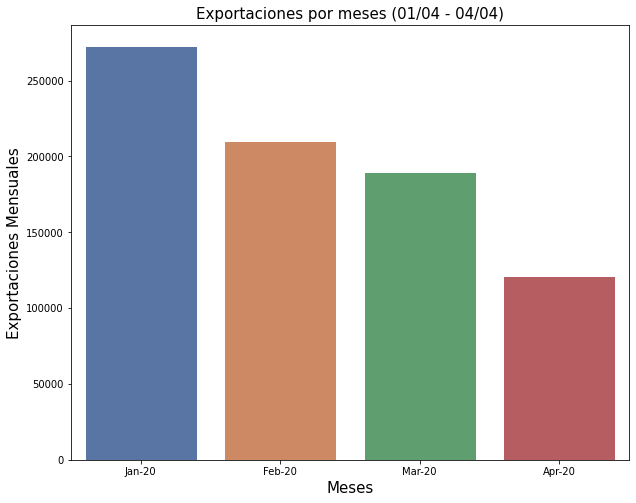

In [ ]:
#Grafico que muestra el total de exportaciones por los 4 meses filtrados

fig, ax = plt.subplots(figsize = (10, 8))
sns.set_style("darkgrid")
graf = sns.barplot(x=np.array(data['MONTH']).astype(int), y=np.array(data['ALL_VAL_MO']).astype(int), data=data, color='blue', palette ='deep', ci = None, ax= ax, )
graf.set_xlabel("Meses", fontsize = 15)
graf.set_ylabel("Exportaciones Mensuales", fontsize = 15)
graf.set_xticklabels(["Jan-20","Feb-20","Mar-20","Apr-20"])
graf.set_title("Exportaciones por meses (01/04 - 04/04)", fontsize = 15)